# PyMPS demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.linalg as la
from pymps import *
import matplotlib.pyplot as plt

from pygsvd import gsvd

## Example 1: Rectangle

PyMPS is a package for computing Laplacian eigenvalues using the Method of Particular Solutions. It includes the base MPS code, as well as a mesh-based version for computing approximate $L^2$-orthonormal eigenbases. It also allows the user to compute derivatives of eigenvalues with respect to polygon vertex coordinates.

First, we set up a basic rectangular problem with simple eigenvalues.

In [3]:
# set up rectangle
L,H = np.pi,2
x_v, y_v = [0,L,L,0], [0,0,H,H]
rect_vertices = np.array([x_v,y_v]).T

# build quadrature mesh
# this allows the solver to compute approximate L^2 orthonormal eigenbases
mesh = triangular_mesh(rect_vertices,1)
int_nodes, int_weights = tri_quad(mesh)
bdry_nodes, bdry_weights = boundary_nodes(rect_vertices,20)

# construct eigenproblem object
# we use 40 Fourier-Bessel functions centered at the bottom-left corner
# the eigenproblem object defaults to placing 20 points along each side,
# but will skip sides where all basis functions are known to be zero
# it defaults to placing 50 interior points at random in the domain
EP_rect = PolygonEP(rect_vertices,[40,0,0,0],boundary_method='chebyshev',bdry_nodes=bdry_nodes,
                    bdry_weights=bdry_weights,int_nodes=int_nodes,int_weights=int_weights)

# setting the rtol to a higher value due to the regular corner
EP_rect.rtol = 1e-16

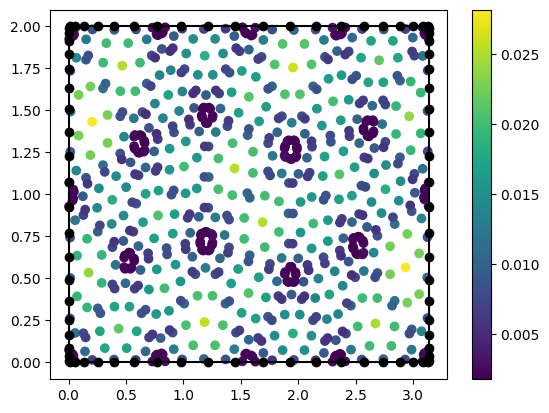

In [4]:
fig = plt.figure()
ax = plt.gca()
plot_polygon(x_v,y_v,ax=ax)
intpts = ax.scatter(int_nodes[:,0],int_nodes[:,1],c=int_weights,cmap='viridis')
plt.colorbar(intpts)
ax.scatter(bdry_nodes[:,0],bdry_nodes[:,1],c='k')
plt.show()

### Visualizing the subspace angle curve $\sigma(\lambda)$

We want to visualize the subspace angle curve $\sigma(\lambda)$ to see if our choice of basis and collocation points is sufficient. Below we can see that the minima of $\sigma(\lambda)$ are close to the true eigenvalues for the rectangle.

In [5]:
# get scalars up to lambda=lambda_max
lambda_max = 25
n_lambda = 1000
Lambda = np.linspace(0,lambda_max,n_lambda)[1:]

# compute sigma(lambda) for various lambda_
sigma = []
for lambda_ in Lambda:
    sigma.append(EP_rect.sigma(lambda_))
    
# identify which true eigenvalues are below lambda_max (for plotting)
m_n = rect_eig_bound_idx(lambda_max,L,H)

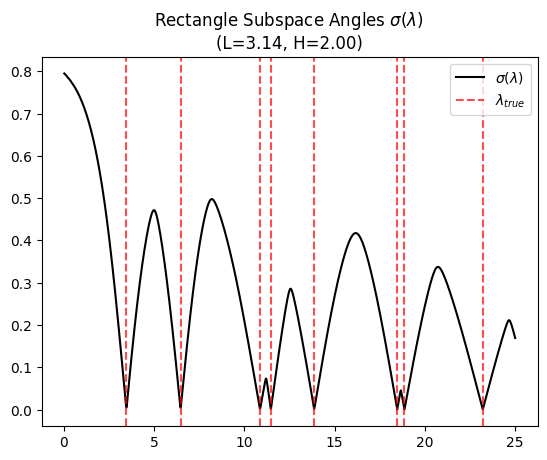

In [8]:
fig = plt.figure()
plt.plot(Lambda,sigma,label='$\\sigma(\\lambda)$',c='k')

# plot vertical lines at true eigenvalues
label = '$\\lambda_{true}$'
for m,n in m_n:
    plt.axvline(rect_lambda(m,n,L,H),c='r',linestyle='--',alpha=.7,label=label)
    label = None
plt.legend()
plt.title(f'Rectangle Subspace Angles $\\sigma(\\lambda)$ \n(L={L:.2f}, H={H:.2f})')
plt.show()

When $\sigma(\lambda)$ is near zero, MPS has located an approximate eigenvalue. This is because $\sigma(\lambda)$ is the sine of the angle between the subspace spanned by our Fourier-Bessel basis and the subspace of functions which are zero on the boundary collocation points.

### Testing accuracy of MPS minima

The better the basis and collocation points, the better the minima of $\sigma(\lambda)$ will approximate true eigenvalues. We can use a Golden ratio search to rapidly find the minima of $\sigma(\lambda)$.

In [11]:
# check up to lambda=100
m_n = rect_eig_bound_idx(100,L,H)
Lambda = rect_lambda(*m_n.T,L,H)
sort_idx = Lambda.argsort()
m_n = m_n[sort_idx]
lambda_err = []
for m,n in m_n:
    lambda_mn_true = rect_lambda(m,n,L,H)
    lambda_mn = golden_search(EP_rect.sigma,lambda_mn_true-.1,lambda_mn_true+.1)[0]
    err = np.abs((lambda_mn-lambda_mn_true)/lambda_mn_true)
    lambda_err.append(err)
    print(f'lambda ({m},{n})={lambda_mn_true:.3f}, err={err:.3e}')

lambda (1,1)=3.467, err=5.123e-16
lambda (2,1)=6.467, err=4.120e-16
lambda (1,2)=10.870, err=1.634e-16
lambda (3,1)=11.467, err=1.549e-16
lambda (2,2)=13.870, err=1.281e-16
lambda (4,1)=18.467, err=3.848e-16
lambda (3,2)=18.870, err=1.883e-16
lambda (1,3)=23.207, err=1.531e-16
lambda (4,2)=25.870, err=0.000e+00
lambda (2,3)=26.207, err=1.356e-16
lambda (5,1)=27.467, err=2.587e-16
lambda (3,3)=31.207, err=0.000e+00
lambda (5,2)=34.870, err=0.000e+00
lambda (4,3)=38.207, err=1.860e-16
lambda (6,1)=38.467, err=1.847e-16
lambda (1,4)=40.478, err=1.755e-16
lambda (2,4)=43.478, err=0.000e+00
lambda (6,2)=45.870, err=1.549e-16
lambda (5,3)=47.207, err=1.505e-16
lambda (3,4)=48.478, err=1.466e-16
lambda (7,1)=51.467, err=1.381e-16
lambda (4,4)=55.478, err=0.000e+00
lambda (6,3)=58.207, err=0.000e+00
lambda (7,2)=58.870, err=0.000e+00
lambda (1,5)=62.685, err=1.134e-16
lambda (5,4)=64.478, err=0.000e+00
lambda (2,5)=65.685, err=0.000e+00
lambda (8,1)=66.467, err=2.138e-16
lambda (3,5)=70.685, e

In [45]:
print(len(m_n))

42


In this case, we obtain the first 42 eigenvalues $\lambda < 100$ to machine precision.

### Eigenfunctions

With the mesh and weights incorporated, we can have MPS solve for approximate eigenfunctions with unit $L^2$ norm. The PolygonEP object can return a callable function for eigenfunctions corresponding to specific eigenvalues.

In [7]:
# extract eigenfunction for (1,1) eigenvalue
u_11 = EP_rect.eigenbasis(rect_lambda(1,1,L,H))

# build grid on the rectangle
n = 100
x,y = np.linspace(0,L,n), np.linspace(0,H,n)
X,Y = np.meshgrid(x,y,indexing='ij')

# evaluate eigenfunction on the grid
U = u_11(X,Y)[:,:,0]

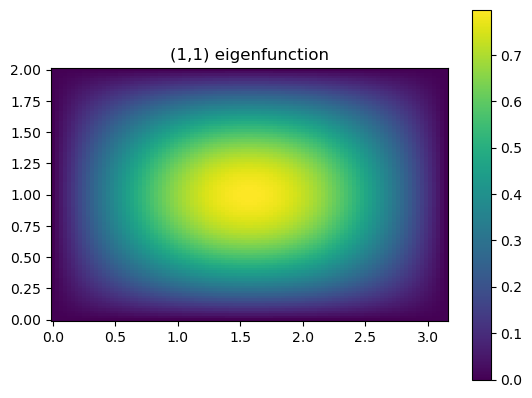

In [8]:
# plot
fig = plt.figure()
plt.pcolormesh(X,Y,U)
plt.colorbar()
plt.title('(1,1) eigenfunction')
plt.gca().set_aspect('equal')
plt.show()

We can compare this to the true unit eigenfunction to see how accurate we are.

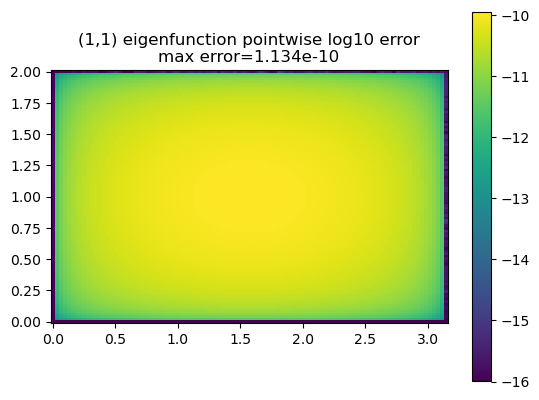

In [9]:
# true eigenfunction & evaluation
utrue = lambda x,y,m,n,L,H: (2/np.sqrt(L*H))*np.sin(np.pi*m/L*x)*np.sin(np.pi*n/H*y)
U_true = utrue(X,Y,1,1,L,H)

# catching sign difference on arbitrary point
sign = np.sign(U.flatten()[1234]*U_true.flatten()[1234])
# computing error
err = np.abs(U-sign*U_true)

# plotting log10 error
fig = plt.figure()
plt.pcolormesh(X,Y,np.log10(err+1e-16))
plt.colorbar()
plt.title(f'(1,1) eigenfunction pointwise log10 error'+'\n'+f'max error={err.max():.3e}')
plt.gca().set_aspect('equal')
plt.show()

We see that we recover the true unit eigenfunction to no fewer than 14 digits of accuracy throughout the whole domain.

Let's look at the more eigenmodes, and their reconstruction errors.

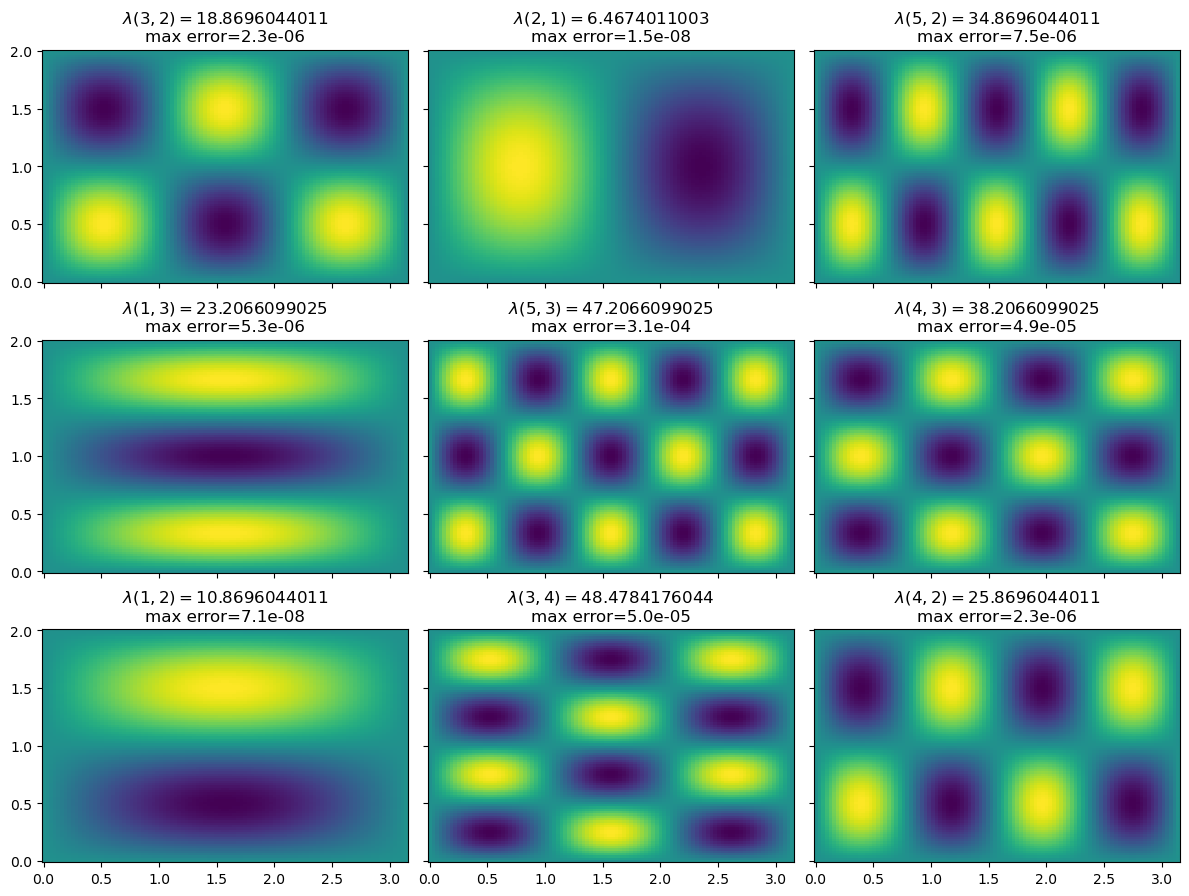

In [12]:
fig, axs = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs = axs.flatten()

for (m,n), ax in zip(m_n[sort_idx][1:11],axs):
    lambda_mn = rect_lambda(m,n,L,H)
    u = EP_rect.eigenbasis(lambda_mn)
    U = u(X,Y)
    U_true = utrue(X,Y,m,n,L,H)
    sign = np.sign(U.flatten()[1234]*U_true.flatten()[1234])
    err = np.abs(np.abs(U[:,:,0]-sign*U_true))/np.max(np.abs(U_true))
    ax.pcolormesh(X,Y,U[:,:,0])
    ax.set_title(f'$\lambda({m},{n})={lambda_mn:.10f}$\nmax error={err.max():.1e}')
    ax.set_aspect('equal')
plt.tight_layout()
plt.show()

Here is a plot showing the eigenfunction reconstruction $L^\infty$ error for all eigenvalues $\lambda<100$.

In [13]:
m_n = rect_eig_bound_idx(100,L,H)
Lambda = rect_lambda(*m_n.T,L,H)
sort_idx = Lambda.argsort()
Lambda = Lambda[sort_idx]
m_n = m_n[sort_idx]

infty_err = []
for m,n in m_n:
    lambda_mn = rect_lambda(m,n,L,H)
    u = EP_rect.eigenbasis(lambda_mn)
    U = u(X,Y)
    U_true = utrue(X,Y,m,n,L,H)
    sign = np.sign(U.flatten()[1234]*U_true.flatten()[1234])
    infty_err.append((np.abs(U[:,:,0]-sign*U_true).max())/np.abs(U_true).max())

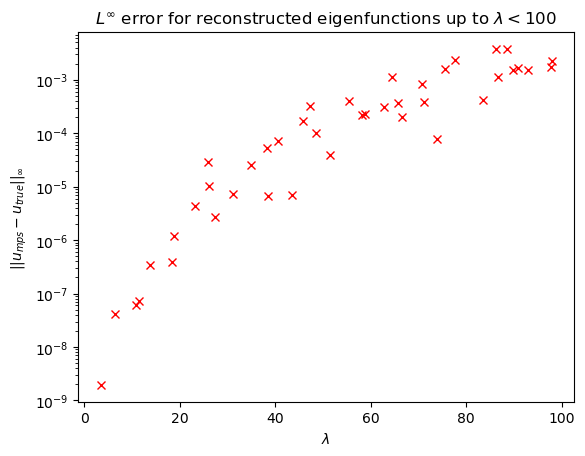

In [51]:
fig = plt.figure()
plt.semilogy(Lambda,infty_err,'rx')
plt.xlabel('$\lambda$')
plt.ylabel('$||u_{mps}-u_{true}||_\infty$')
plt.title('$L^\infty$ error for reconstructed eigenfunctions up to $\lambda<100$')
plt.show()

## Example 2: L-Shaped Domain

Here we work with the famous L-shaped domain that Trefethen and Beckte conquered in their paper. Let's see how we do!

In [53]:
x_v, y_v = [0,1,1,-1,-1,0], [0,0,1,1,-1,-1]
L_vertices = np.array([x_v,y_v]).T

# build quadrature mesh
mesh = triangular_mesh(L_vertices,1)
int_nodes, int_weights = tri_quad8(mesh)
bdry_nodes, bdry_weights = boundary_nodes(L_vertices,140)

# construct eigenproblem object
# we expand only around the rentrant corner
EP_L = PolygonEP(L_vertices,[140,0,0,0,0,0],boundary_pts=140,boundary_method='even',bdry_nodes=bdry_nodes,
                    bdry_weights=bdry_weights,int_nodes=int_nodes,int_weights=int_weights)
EP_L.rtol=0

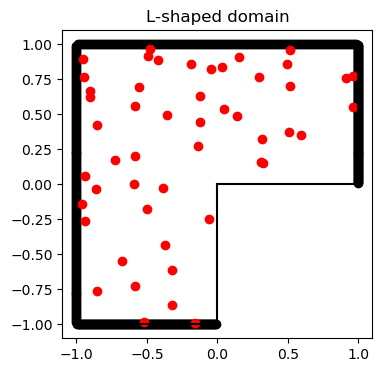

In [54]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
plot_polygon(x_v,y_v,ax=ax)
ax.scatter(EP_L.boundary_pts[:,0],EP_L.boundary_pts[:,1],c='k')
ax.scatter(EP_L.interior_pts[:,0],EP_L.interior_pts[:,1],c='r')
# ax.set_aspect('equal')
plt.title('L-shaped domain')
# plt.show()
plt.savefig('figures/L_domain.pdf')

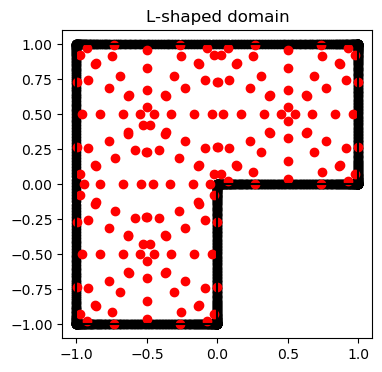

In [55]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
plot_polygon(x_v,y_v,ax=ax)
ax.scatter(EP_L.bdry_nodes[:,0],EP_L.bdry_nodes[:,1],c='k')
ax.scatter(EP_L.int_nodes[:,0],EP_L.int_nodes[:,1],c='r')
# ax.set_aspect('equal')
plt.title('L-shaped domain')
# plt.show()
plt.savefig('figures/L_domain2.pdf')

### Visualizing the subspace angle curve $\sigma(\lambda)$

In [56]:
# get scalars up to lambda=lambda_max
lambda_max = 50
n_lambda = 1000
Lambda = np.linspace(0,lambda_max,n_lambda)[1:]

# compute sigma(lambda) for various lambda_
sines = []
for lambda_ in Lambda:
    sines.append(EP_L.weighted_subspace_sines(lambda_))

In [57]:
sines = np.array(sines)

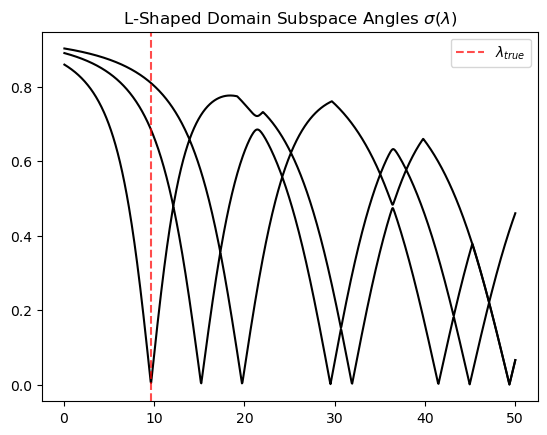

In [58]:
fig = plt.figure()
plt.plot(Lambda,sines[:,:3],c='k')

# plot vertical lines at true eigenvalues
label = '$\lambda_{true}$'
for lambda_ in [9.6397238440219]:
    plt.axvline(lambda_,c='r',linestyle='--',alpha=.7,label=label)
    label = None
plt.legend()
plt.title(f'L-Shaped Domain Subspace Angles $\sigma(\lambda)$')
# plt.show()
plt.savefig('figures/sigma_L.pdf')

Trefethen and Betcke give their estimate, proven correct to 13 digits, as 9.6397238440219. When we use Golden search to find our minima, we obtain the same first 13 digits.

### Eigenfunctions

We visualize the first few eigenfunctions on the L-shaped domain:

In [59]:
x,y = np.linspace(-1,1,100),np.linspace(-1,1,100)
X,Y = np.meshgrid(x,y,indexing='ij')
mask = ((X>0)&(Y<0))

In [62]:
lambda_1 = golden_search(EP_L.sigma,9,11)[0]
lambda_2 = golden_search(EP_L.sigma,15,16)[0]
lambda_3 = golden_search(EP_L.sigma,16,20)[0]
lambda_4 = golden_search(EP_L.sigma,25,30)[0]

In [63]:
u_1 = EP_L.eigenbasis(lambda_1)
u_2 = EP_L.eigenbasis(lambda_2)
u_3 = EP_L.eigenbasis(lambda_3)
u_4 = EP_L.eigenbasis(lambda_4)

U_1 = u_1(X,Y)[:,:,0]
U_2 = u_2(X,Y)[:,:,0]
U_3 = u_3(X,Y)[:,:,0]
U_4 = u_4(X,Y)[:,:,0]

U_1[mask] = np.nan
U_2[mask] = np.nan
U_3[mask] = np.nan
U_4[mask] = np.nan

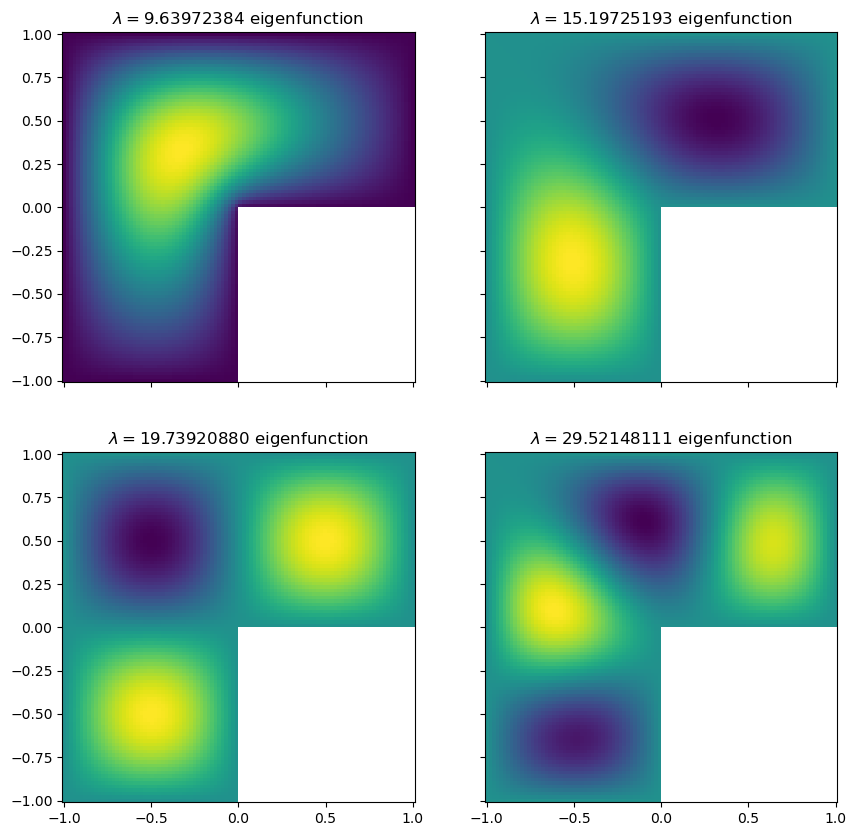

In [64]:
fig,axs = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
axs = axs.flatten()

axs[0].pcolormesh(X,Y,U_1)
axs[0].set_title(f'$\lambda={lambda_1:.8f}$ eigenfunction')

axs[1].pcolormesh(X,Y,U_2)
axs[1].set_title(f'$\lambda={lambda_2:.8f}$ eigenfunction')

axs[2].pcolormesh(X,Y,U_3)
axs[2].set_title(f'$\lambda={lambda_3:.8f}$ eigenfunction')

axs[3].pcolormesh(X,Y,U_4)
axs[3].set_title(f'$\lambda={lambda_4:.8f}$ eigenfunction')
plt.show()

We can confirm that these are unit eigenfunctions by taking their evaluations on the quadrature mesh and estimating their integrals. We can also confirm pairwise orthogonality!

In [65]:
u_1_mesh = EP_L.eigenbasis_node_eval(lambda_1)[:,0]
u_2_mesh = EP_L.eigenbasis_node_eval(lambda_2)[:,0]
u_3_mesh = EP_L.eigenbasis_node_eval(lambda_3)[:,0]
u_4_mesh = EP_L.eigenbasis_node_eval(lambda_4)[:,0]
u_mesh = [u_1_mesh,u_2_mesh,u_3_mesh,u_4_mesh]

In [66]:
# empty gram matrix
M = np.empty((4,4))
for i in range(4):
    for j in range(4):
        M[i,j] = (EP_L.weights[:,0]*u_mesh[i])@(EP_L.weights[:,0]*u_mesh[j])
        
print(M)

[[ 1.00000000e+00 -5.62339890e-06  6.35740626e-06 -2.68491930e-05]
 [-5.62339890e-06  1.00000000e+00  1.16621553e-06  1.85222343e-05]
 [ 6.35740626e-06  1.16621553e-06  1.00000000e+00  6.42361345e-06]
 [-2.68491930e-05  1.85222343e-05  6.42361345e-06  1.00000000e+00]]


Our eigenfunctions have unit (approximate) $L^2$ norm, as well as approximate $L^2$ orthgonality.

# Example 3: Repeated Eigenvalues on a Square

Due to symmetry, the square has repeated eigenvalues. Here we check to see if (1) we recover the eigenvalues accurately and (2) if we can construct orthonormal eigenbases.

In [150]:
L,H = 1,1
x_v, y_v = [0,L,L,0], [0,0,H,H]
sq_vertices = np.array([x_v,y_v]).T

# build quadrature mesh
mesh = quadrilateral_mesh(sq_vertices,1)
int_nodes, int_weights = quad_quad(mesh,order=10)
bdry_nodes, bdry_weights = boundary_nodes(sq_vertices,20)

# construct eigenproblem object
EP_sq = PolygonEP(sq_vertices,[60,0,0,0],bdry_nodes=bdry_nodes,
                    bdry_weights=bdry_weights,int_nodes=int_nodes,int_weights=int_weights)
EP_sq.rtol = 1e-15
EP_sq.btol = 2e3

In [151]:
# get scalars up to lambda=lambda_max
lambda_max = 200
n_lambda = 1000
Lambda = np.linspace(0,lambda_max,n_lambda)[1:]

# compute sigma(lambda) for various lambda_
sigma = []
for lambda_ in Lambda:
    sigma.append(EP_sq.sigma(lambda_))
    
# identify which true eigenvalues are below lambda_max (for plotting)
m_n = rect_eig_bound_idx(lambda_max,L,H)

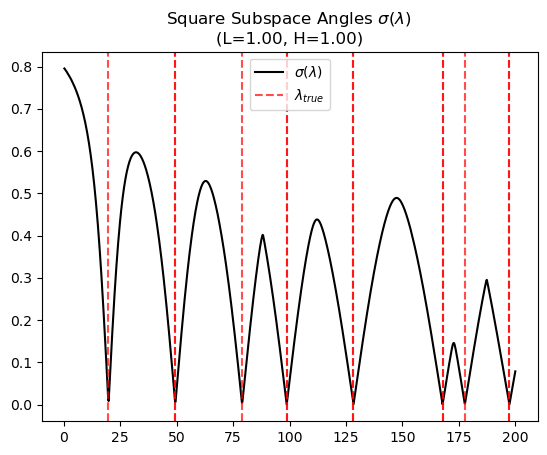

In [152]:
fig = plt.figure()
plt.plot(Lambda,sigma,label='$\sigma(\lambda)$',c='k')

# plot vertical lines at true eigenvalues
label = '$\lambda_{true}$'
for m,n in m_n:
    plt.axvline(rect_lambda(m,n,L,H),c='r',linestyle='--',alpha=.7,label=label)
    label = None
plt.legend()
plt.title(f'Square Subspace Angles $\sigma(\lambda)$ \n(L={L:.2f}, H={H:.2f})')
plt.show()

### Testing accuracy of MPS minima and eigendimension

The eigenvalues for the square come in pairs, triads, quads, and so forth. Can we discover the multiple eigenvalues?

In [153]:
# check up to lambda=1000
m_n = rect_eig_bound_idx(1000,L,H)
Lambda = rect_lambda(*m_n.T,L,H)
sort_idx = Lambda.argsort()
Lambda = Lambda[np.unique(Lambda.round(12), return_index=True)[1]]

lambda_err = []
true_mults = []
i = 1
for lambda_mn_true in Lambda:
    lambda_mn = golden_search(EP_sq.sigma,lambda_mn_true-.1,lambda_mn_true+.1)
    mult = EP_sq.sigma(lambda_mn,mult_check=True)[1]
    true_mult = len(rect_eig_mult(lambda_mn_true,L,H)[0])
    err = abs(lambda_mn-lambda_mn_true)
    lambda_err.append(err)
    flag = ' ✓'
    if mult!=true_mult: flag = '***'
    true_mults.append(true_mult)
    print(f'lambda {i} = {lambda_mn_true:.3f}\terr={err:.3e}\ttrue_mult={true_mult}\test_mult={mult}'+flag)
    i+=1

lambda 1 = 19.739	err=3.553e-15	true_mult=1	est_mult=1 ✓
lambda 2 = 49.348	err=7.105e-15	true_mult=2	est_mult=2 ✓
lambda 3 = 78.957	err=1.421e-14	true_mult=1	est_mult=1 ✓
lambda 4 = 98.696	err=1.421e-14	true_mult=2	est_mult=2 ✓
lambda 5 = 128.305	err=0.000e+00	true_mult=2	est_mult=2 ✓
lambda 6 = 167.783	err=2.842e-14	true_mult=2	est_mult=2 ✓
lambda 7 = 177.653	err=0.000e+00	true_mult=1	est_mult=1 ✓
lambda 8 = 197.392	err=2.842e-14	true_mult=2	est_mult=2 ✓
lambda 9 = 246.740	err=0.000e+00	true_mult=2	est_mult=2 ✓
lambda 10 = 256.610	err=1.137e-13	true_mult=2	est_mult=2 ✓
lambda 11 = 286.219	err=5.684e-14	true_mult=2	est_mult=2 ✓
lambda 12 = 315.827	err=5.684e-14	true_mult=1	est_mult=1 ✓
lambda 13 = 335.567	err=5.684e-14	true_mult=2	est_mult=2 ✓
lambda 14 = 365.175	err=0.000e+00	true_mult=2	est_mult=2 ✓
lambda 15 = 394.784	err=5.684e-14	true_mult=2	est_mult=2 ✓
lambda 16 = 404.654	err=1.137e-13	true_mult=2	est_mult=2 ✓
lambda 17 = 444.132	err=1.137e-13	true_mult=2	est_mult=2 ✓
lambda 18 

In [154]:
np.sum(true_mults)

71

Counting multiplicity, we obtain the first 71 eigenvalues $\lambda < 1000$ to 12 or more digits of accuracy. We also perfectly identify the multiplicity of each eigenvalue.

### Eigenbases

When eigenvalues are repeated, we obtain higher-dimensional eigenspaces. To make effective use of the eigenfunctions, we need to orthogonalize them in $L^2.$ Conveniently enough, our MPS implementation does this automatically.

For example, $\lambda \approx 641.524$ has multiplicity 4. We extract the eigenbasis coefficients...

In [155]:
lambda_ = rect_lambda(4,7,L,H)
C = EP_sq.eigenbasis_coef(lambda_)
C.shape

(60, 4)

...and note that there are four sets of coefficients, one for each of four eigenfunctions.

Let's check that they are approximately $L^2$ orthonormal.

In [156]:
U = EP_sq.eigenbasis_node_eval(lambda_)
np.round((EP_sq.weights*U).T@(EP_sq.weights*U),16)

array([[ 1.e+00, -1.e-15,  0.e+00, -1.e-16],
       [-1.e-15,  1.e+00,  0.e+00,  2.e-16],
       [ 0.e+00,  0.e+00,  1.e+00, -2.e-16],
       [-1.e-16,  2.e-16, -2.e-16,  1.e+00]])

Indeed, they are approximately orthonormal. Let's take a look at them graphically.

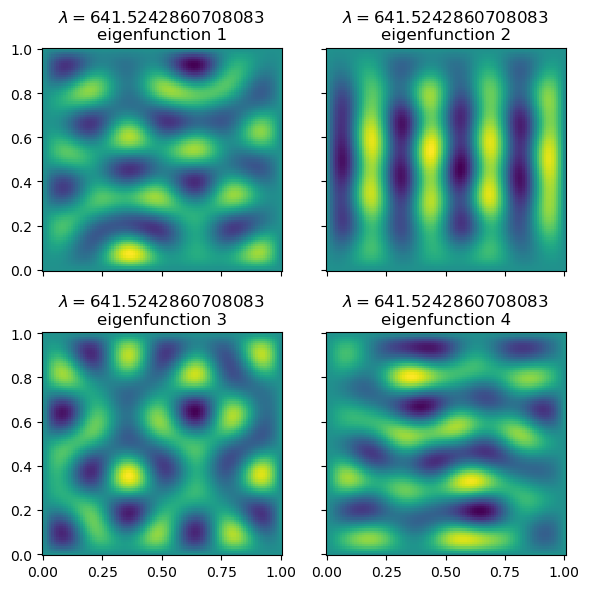

In [157]:
x,y = np.linspace(0,1,100),np.linspace(0,1,100)
X,Y = np.meshgrid(x,y,indexing='ij')
U = EP_sq.eigenbasis(lambda_)(X,Y)

fig,axs = plt.subplots(2,2,figsize=(6,6),sharex=True,sharey=True)
axs = axs.flatten()
for i in range(4):
    axs[i].pcolormesh(X,Y,U[:,:,i])
    axs[i].set_title(f'$\lambda={lambda_}$\neigenfunction {i+1}')
plt.tight_layout()
plt.show()

The eigenbases for repeated eigenvalues are not unique, so we don't expect them to exhibit the regular structure of simple eigenfunctions on the rectangle. Nonetheless, we don't need them to be "axes-aligned" in order to be useful in computation.